In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from nilearn import plotting

from src import data,centroids,paths,matrix_filtering

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-05-17


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1","schaefer"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "MNI-HCP-MMP1"
min_streamlines = 5
graph_density = 0.25

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

fig_dir = f"sc_comparison/{PARCELLATION}/{min_streamlines}/{graph_density}/"
%mkdir -p {paths.path_figures(fig_dir)}

## Load data

### Load structural connectivity data

In [3]:
SC_matrices = []

if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=min_streamlines)
    centroid_coords = None

elif PARCELLATION == "MNI-HCP-MMP1":
    ftract_labels = data.load_ftract_labels(PARCELLATION)
    centroid_coords = centroids.load_glasser_centroids(ftract_labels=ftract_labels)
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED=ED,min_streamlines_count=min_streamlines)

elif PARCELLATION == "schaefer":
    ED = centroids.schaefer_roi_distances()
    SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit(ED=ED,min_streamlines_count=min_streamlines)  
    centroids_file = paths.path('interim/schaefer_parcellation_mappings/ROI_MAPPING_pytepfit.csv')
    centroid_coords = centroids.get_centroids_from_file(centroids_file,"geom_csv")

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [4]:
SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,graph_density)
    SC_W = np.where(SC_W>=pivot,SC_W,np.nan)
    np.fill_diagonal(SC_W,0)
    np.nan_to_num(SC_W,nan=0,copy=False)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

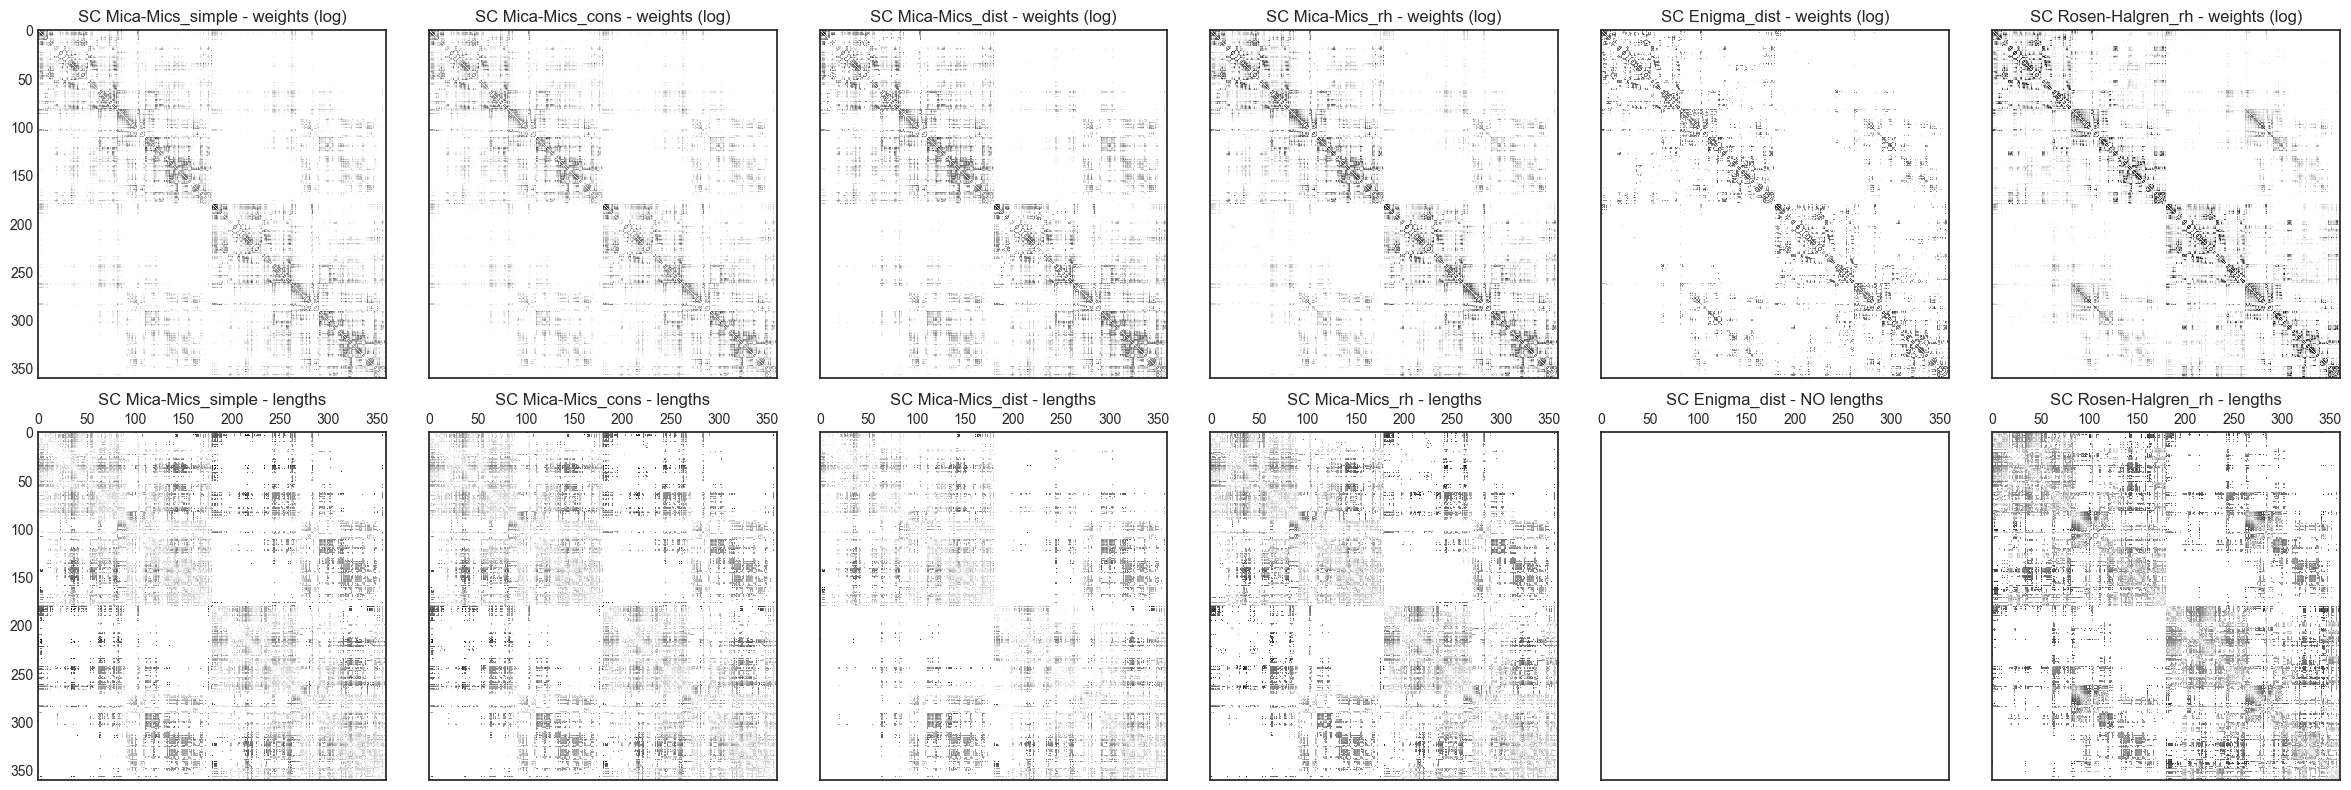

In [5]:
plt.rcParams['figure.figsize'] = [4*number_of_SC,8]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i in range(number_of_SC):
    name, SC_W, SC_L, SC_W_log = SC_matrices[i]

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")
 
    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

plt.savefig(paths.path_figures(fig_dir+"sc_matrices.pdf"))

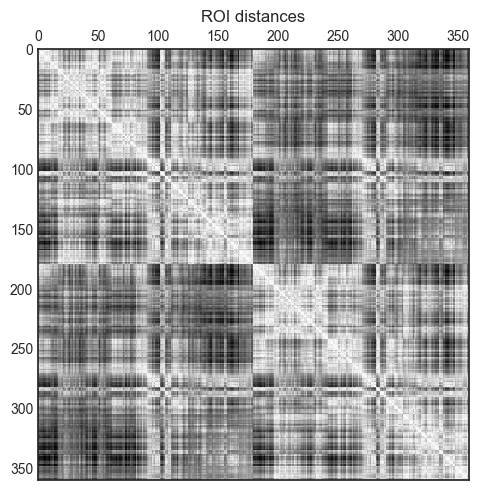

In [6]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

In [7]:
plt.style.use('ggplot')

In [8]:
dict_weights = dict()
dict_lengths = dict()

datasets_set = set()
prep_methods_set = set()

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    if len(name.split("_")) >1:
        dataset,prep_method = name.split("_")
    else: 
        dataset = name
        prep_method = '-'

    datasets_set.add(dataset)
    prep_methods_set.add(prep_method)

    if dataset == "Enigma":
        SC_W = np.where(SC_W == 1, 0,SC_W)

    dict_weights[(dataset,prep_method)] = SC_W.flatten()
    
    if SC_L is not None:
        dict_lengths[(dataset,prep_method)] = SC_L.flatten()

df_weights = pd.DataFrame(dict_weights)
df_lengths = pd.DataFrame(dict_lengths)

df_weights

Mica-Mics                                               Enigma  \
              simple          cons          dist        rh           dist   
0            0.00000       0.00000       0.00000  0.000000       0.000000   
1         7482.04564    7482.04564    7482.04564  0.014682    6181.399617   
2       187959.34000  187959.34000  187959.34000  0.231330  201188.991199   
3        89892.30000   89892.30000   89892.30000  0.117899   46770.128584   
4        31206.51200   31206.51200   31206.51200  0.045920    4987.549570   
...              ...           ...           ...       ...            ...   
129595       0.00000       0.00000       0.00000  0.000000       0.000000   
129596    1103.41280    1103.41280    1103.41280  0.009525    4919.194123   
129597       0.00000       0.00000       0.00000  0.000366       0.000000   
129598       0.00000       0.00000       0.00000  0.000556       0.000000   
129599       0.00000       0.00000       0.00000  0.000000       0.000000   

       Rosen-Halgren  
                  rh  
0           0.000000  
1           0.013381  
2           0.142687  
3           0.062711  
4           0.019655  
...              ...  
129595      0.001624  
129596      0.053595  
129597      0.001768  
129598      0.002784  
129599      0.000000  

[129600 rows x 6 columns]

In [9]:
def select_df_by_dataset(df,dataset):
    return df.xs(dataset, level=0, axis=1)

def select_df_by_prep_method(df,method):
    return df.xs(method, level=1, axis=1)

In [10]:
def minmax_norm(column):
    return (column - column.min()) / (column.max() - column.min())

In [11]:
columns = list(df_weights.columns)

df_weights_normalized = df_weights.copy()

for col in columns:
    df_weights_normalized[col] = minmax_norm(df_weights_normalized[col])
df_weights_normalized

Mica-Mics                                  Enigma Rosen-Halgren
          simple      cons      dist        rh      dist            rh
0       0.000000  0.000000  0.000000  0.000000  0.000000      0.000000
1       0.039185  0.039185  0.039185  0.063466  0.028362      0.092941
2       0.984389  0.984389  0.984389  1.000000  0.923116      0.991071
3       0.470788  0.470788  0.470788  0.509658  0.214596      0.435573
4       0.163436  0.163436  0.163436  0.198503  0.022884      0.136519
...          ...       ...       ...       ...       ...           ...
129595  0.000000  0.000000  0.000000  0.000000  0.000000      0.011277
129596  0.005779  0.005779  0.005779  0.041174  0.022571      0.372257
129597  0.000000  0.000000  0.000000  0.001582  0.000000      0.012279
129598  0.000000  0.000000  0.000000  0.002402  0.000000      0.019336
129599  0.000000  0.000000  0.000000  0.000000  0.000000      0.000000

[129600 rows x 6 columns]

In [12]:
df_weights.astype(bool).sum(axis=0)

Mica-Mics      simple    32400
               cons      32400
               dist      21318
               rh        32400
Enigma         dist       9158
Rosen-Halgren  rh        32040
dtype: int64

In [13]:
df_weights.describe().T

count        mean          std  min  25%  50%  \
Mica-Mics     simple  129600.0  225.737296  1671.846256  0.0  0.0  0.0   
              cons    129600.0  226.787836  1672.050433  0.0  0.0  0.0   
              dist    129600.0  206.497528  1667.953447  0.0  0.0  0.0   
              rh      129600.0    0.001108     0.005146  0.0  0.0  0.0   
Enigma        dist    129600.0  125.731271  1580.161258  0.0  0.0  0.0   
Rosen-Halgren rh      129600.0    0.001208     0.006221  0.0  0.0  0.0   

                            75%            max  
Mica-Mics     simple  12.838060  190940.200000  
              cons    14.287906  190940.200000  
              dist     0.000000  190940.200000  
              rh       0.000090       0.231330  
Enigma        dist     0.000000  217945.432324  
Rosen-Halgren rh       0.000000       0.143973

In [14]:
correlations = pg.pairwise_corr(df_weights,method="spearman")
correlations

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,"(Mica-Mics, simple)","(Mica-Mics, cons)",spearman,two-sided,129600,0.979786,"[0.98, 0.98]",0.0,1.0
1,"(Mica-Mics, simple)","(Mica-Mics, dist)",spearman,two-sided,129600,0.783871,"[0.78, 0.79]",0.0,1.0
2,"(Mica-Mics, simple)","(Mica-Mics, rh)",spearman,two-sided,129600,0.903112,"[0.9, 0.9]",0.0,1.0
3,"(Mica-Mics, simple)","(Enigma, dist)",spearman,two-sided,129600,0.513600,"[0.51, 0.52]",0.0,1.0
4,"(Mica-Mics, simple)","(Rosen-Halgren, rh)",spearman,two-sided,129600,0.746280,"[0.74, 0.75]",0.0,1.0
5,"(Mica-Mics, cons)","(Mica-Mics, dist)",spearman,two-sided,129600,0.770037,"[0.77, 0.77]",0.0,1.0
6,"(Mica-Mics, cons)","(Mica-Mics, rh)",spearman,two-sided,129600,0.911361,"[0.91, 0.91]",0.0,1.0
7,"(Mica-Mics, cons)","(Enigma, dist)",spearman,two-sided,129600,0.513693,"[0.51, 0.52]",0.0,1.0
8,"(Mica-Mics, cons)","(Rosen-Halgren, rh)",spearman,two-sided,129600,0.741990,"[0.74, 0.74]",0.0,1.0
9,"(Mica-Mics, dist)","(Mica-Mics, rh)",spearman,two-sided,129600,0.735999,"[0.73, 0.74]",0.0,1.0


In [15]:
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.style.use('ggplot')

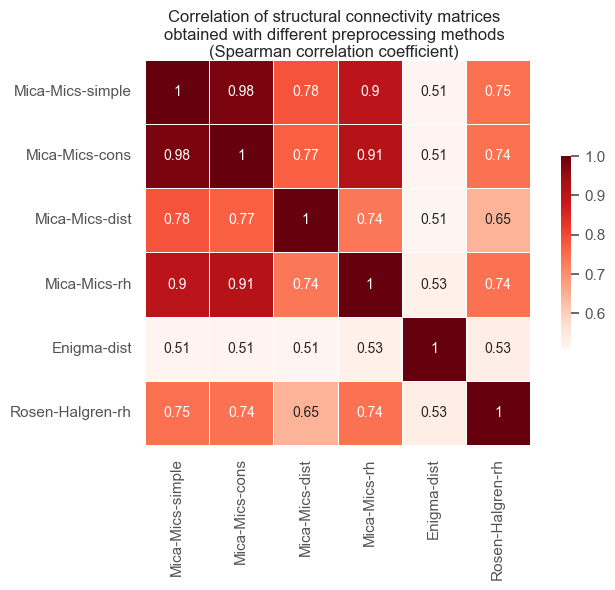

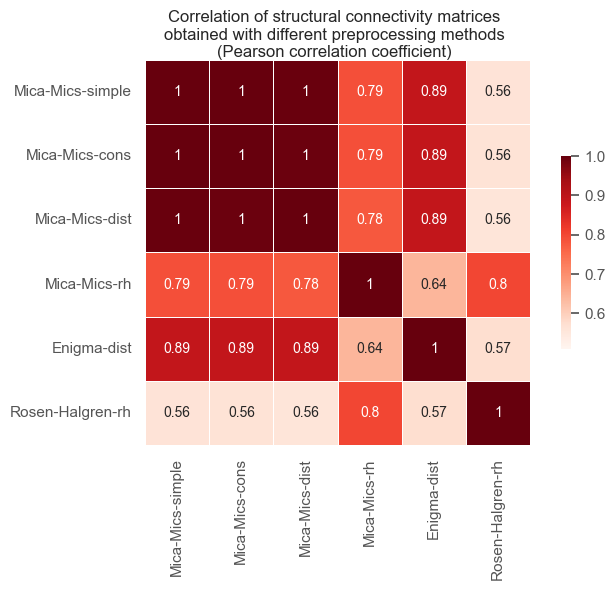

In [16]:
for corr_m in ['Spearman','Pearson']:
    ax = sns.heatmap(df_weights.corr(method=corr_m.lower()), cmap="Reds",vmax=1, vmin=min(correlations["r"]),
                square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
    ax.set(xlabel="", ylabel="")
    plt.suptitle(f"Correlation of structural connectivity matrices\nobtained with different preprocessing methods\n({corr_m} correlation coefficient)")
    plt.savefig(paths.path_figures(fig_dir+f"correlations_all_matrices_{corr_m}.pdf"),bbox_inches='tight',pad_inches=0)
    plt.show()


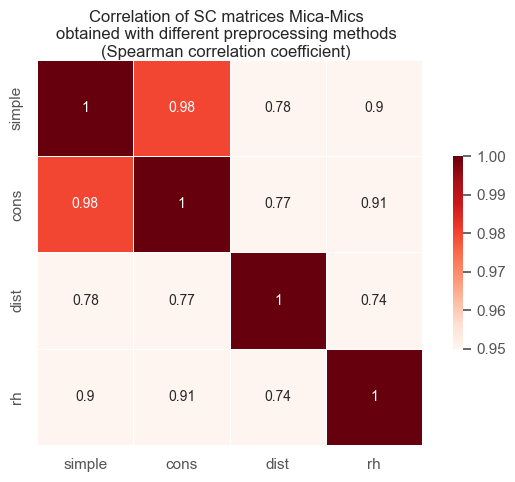

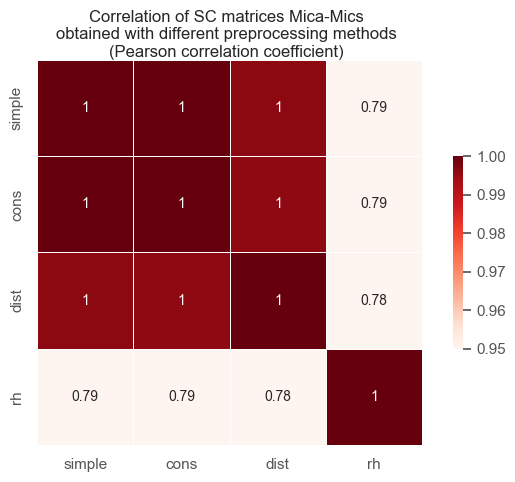

In [17]:
for corr_m in ['Spearman','Pearson']:
    for ds in ["Mica-Mics","Domhof"]:
        if ds not in datasets_set:
            continue
        df_filterd = select_df_by_dataset(df_weights,ds)
        ax = sns.heatmap(df_filterd.corr(method=corr_m.lower()), cmap="Reds",vmax=1, vmin=0.95,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
        ax.set(xlabel="", ylabel="")
        plt.suptitle(f"Correlation of SC matrices {ds}\nobtained with different preprocessing methods\n({corr_m} correlation coefficient)")
        plt.savefig(paths.path_figures(fig_dir+f"correlations_{ds}_{corr_m}.pdf"),bbox_inches='tight',pad_inches=0)
        plt.show()

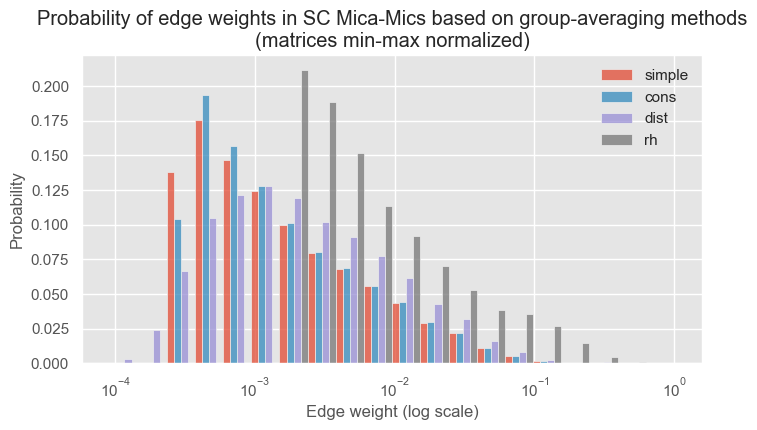

In [18]:
sns.set_theme(rc={'figure.figsize':(8,4)})
plt.style.use('ggplot')

for ds in ["Mica-Mics","Domhof"]:
    if ds not in datasets_set:
        continue
    sns.histplot(select_df_by_dataset(df_weights_normalized,ds),bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge weights in SC {ds} based on group-averaging methods\n(matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

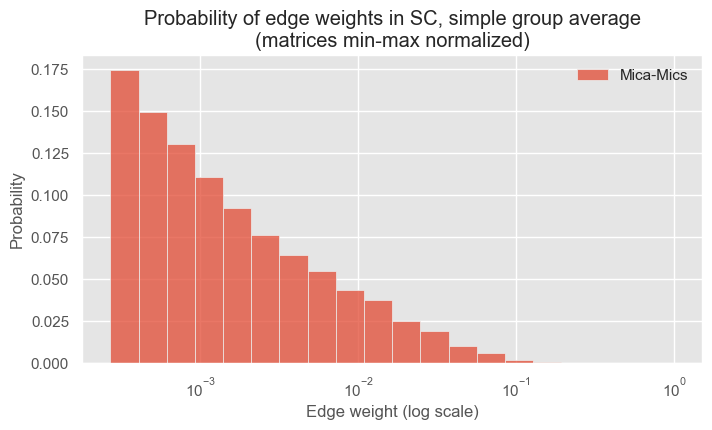

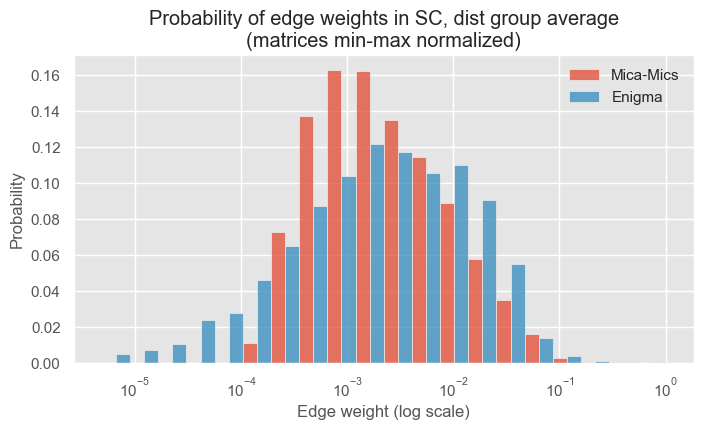

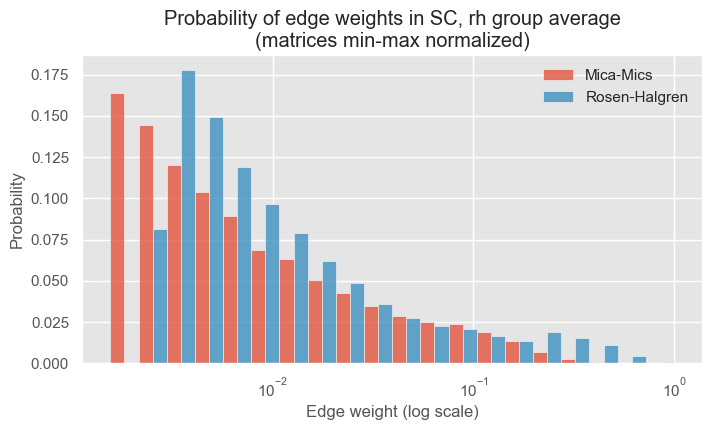

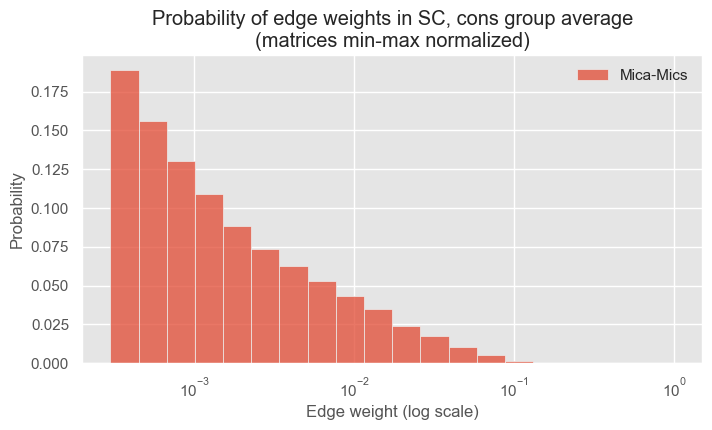

In [19]:
for m in ["simple","dist","rh","cons"]:
    if m not in prep_methods_set:
        continue
    sns.histplot(select_df_by_prep_method(df_weights_normalized,m),bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge weights in SC, {m} group average\n(matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

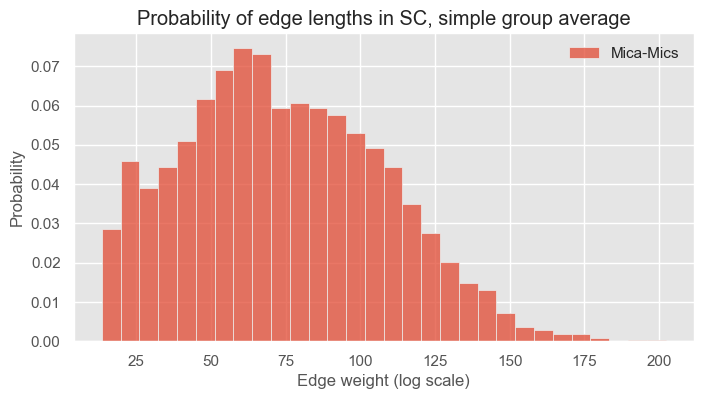

In [20]:
for m in ["simple"]:
    if m not in prep_methods_set:
        continue
    sns.histplot(select_df_by_prep_method(df_lengths,m),bins=30,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge lengths in SC, {m} group average"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()


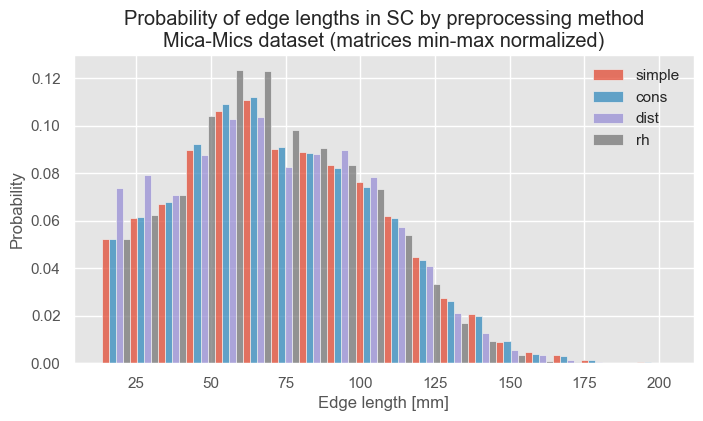

In [21]:
if PARCELLATION != "DKT":    
    sns.histplot(select_df_by_dataset(df_lengths,'Mica-Mics'),bins=20,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge length [mm]")
    title = f"Probability of edge lengths in SC by preprocessing method\nMica-Mics dataset (matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

In [22]:
if centroid_coords is not None:
    # the coordinates are not in MNI space, so we shift them manually for plotting reasons
    for i in range(3):
        centroid_coords[:,i] = centroid_coords[:,i] - ((centroid_coords[:,i].max()-centroid_coords[:,i].min())/2+centroid_coords[:,i].min())
    centroid_coords[:,1]-=12
    centroid_coords[:,2]+=15


    fig, ax= plt.subplots(len(SC_matrices),1,figsize=(15,len(SC_matrices)*4),sharex=True,sharey=True)

    fig.suptitle(f"Average structural connectivity matrices, log-transformed and min-max normalized")

    for i,d in enumerate(SC_matrices):
        name, SC_W, _, SC_W_log = d
        m = np.nan_to_num(SC_W_log,nan=np.nan,posinf=np.nan,neginf=np.nan)

        m = (m - np.nanmin(m,axis=None))
        m = m/np.nanmax(m,axis=None)

        np.fill_diagonal(m,0)

        plotting.plot_connectome(m,centroid_coords,axes=ax[i],node_color="k",node_size=10,title=name,colorbar=True,edge_cmap='Reds',edge_vmin=0.7,edge_vmax=1)

    plt.savefig(paths.path_figures(fig_dir+"connectomes_brain.pdf"))